In [94]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [101]:
cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)


optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle


In [323]:
from backtest import DataParser, MovingWindow
import numpy as np

fsize = 30
X, y = [], []
for btest in btests:
    print(btest.cfg.ticker)
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize)
    for pos in btest.positions:
        f, _ = mw(pos.open_indx)
        fc = f.Close/f.Close[-1]
        fo = f.Open/f.Open[-1]
        fh = f.High/f.High[-1]
        fl = f.Low/f.Low[-1]
        fv = f.Volume/max(1, f.Volume[-1])
        X.append(np.hstack([fc, fo, fl, fh, fv, pos.dir]))
        y.append(pos.profit)
X = np.array(X)
y = np.array(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

profs = y_test
y_train = y_train > 0
y_test = y_test > 0

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

SBER
ROSN
NVTK
LKOH
GMKN
GAZP
(2367, 151) (1015, 151) (2367,) (1015,)


/Users/andrybin/miniforge3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/andrybin/miniforge3/lib/python3.10/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36978
[LightGBM] [Info] Number of data points in the train set: 2367, number of used features: 146
[LightGBM] [Info] Start training from score 0.246726
[1]	val's l2: 0.184656	val's f1: 0
[2]	val's l2: 0.184347	val's f1: 0
[3]	val's l2: 0.183668	val's f1: 0
[4]	val's l2: 0.183449	val's f1: 0
[5]	val's l2: 0.183558	val's f1: 0
[6]	val's l2: 0.184252	val's f1: 0
[7]	val's l2: 0.184682	val's f1: 0
[8]	val's l2: 0.184805	val's f1: 0
[9]	val's l2: 0.184866	val's f1: 0
[10]	val's l2: 0.185168	val's f1: 0
[11]	val's l2: 0.184469	val's f1: 0
[12]	val's l2: 0.184256	val's f1: 0
[13]	val's l2: 0.184241	val's f1: 0
[14]	val's l2: 0.183856	val's f1: 0
[15]	val's l2: 0.184378	val's f1: 0.00787402
[16]	val's l2: 0.184942	val's f1: 0.00787402
[17]	val's l2: 0.184569	val's f1: 0.00787402
[18]	val's l2: 0.18448	v

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='f1'>

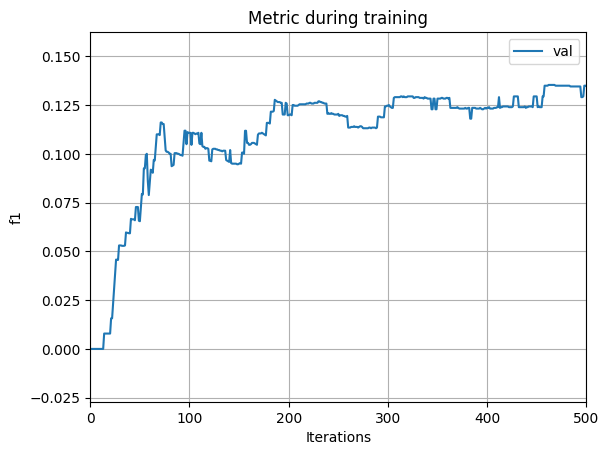

In [324]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

evals_result = {}

# model = lgb.cv(params=dict(learning_rate=0.1, num_leaves=5, max_depth=1), 
#                 train_set=dtrain,
#                 feval=lgb_f1_score
#                 )

model = lgb.train(params=dict(num_iterations=500, num_leaves=20, max_depth=30), 
                train_set=dtrain,
                valid_sets=[dvalid],
                valid_names=['val', 'train'], feval=lgb_f1_score  ,evals_result=evals_result)

lgb.plot_metric(evals_result, metric='f1')
# model = lgb.LGBMClassifier(learning_rate=0.1, num_leaves=5, max_depth=1)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric="auc", early_stopping_rounds=5)

In [325]:
f1_score(model.predict(X_train)>0.25, y_train), f1_score(model.predict(X_test)>0.5, y_test)

(0.9991445680068435, 0.1348973607038123)

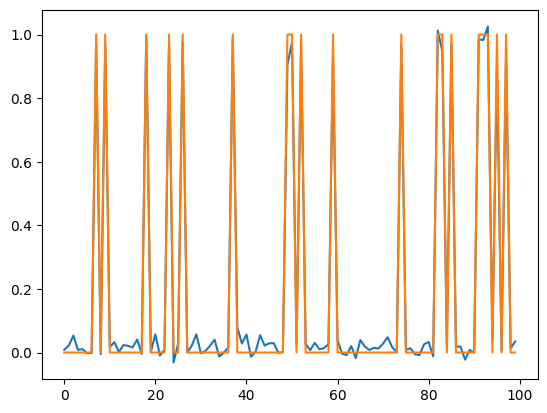

In [326]:
plt.plot(model.predict(X_train[:100]))
plt.plot(y_train[:100])

In [320]:
profs.sum(), (profs*(model.predict(X_test)>0.2)).sum()

(166.11961461682301, 108.9404109593337)

In [102]:
opt_summary = {k:[] for k in cfgs[0].keys()}
for k in opt_summary.keys():
    for cfg in cfgs:
        v = cfg[k]
        if type(v) is EasyDict and "func" in v.keys():
            opt_summary[k].append(str(v.func.name))
        else:
            opt_summary[k].append(v)
            
opt_summary["btest"], opt_summary["ndeals"] = [], []
for btest in btests:
    opt_summary["btest"].append(btest.profits.sum())
    opt_summary["ndeals"].append(len(btest.profits))
    
opt_summary = pd.DataFrame(opt_summary)
opt_summary.sort_values(by=["btest"], ascending=False, inplace=True)
opt_summary = opt_summary[opt_summary.ticker != "NVTK"]
opt_summary.head(10)

,date_start,trailing_stop_rate,trailing_stop_type,body_classifier,stops_processor,wait_entry_point,hist_buffer_size,tstart,tend,period,ticker,data_type,save_plots,btest,ndeals
0,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,SBER,metatrader,False,96.848627,325
1,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,ROSN,metatrader,False,95.741142,238
3,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,LKOH,metatrader,False,44.861520,236
5,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,GAZP,metatrader,False,9.741738,201
4,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,GMKN,metatrader,False,-18.667569,229


In [97]:
opt_res = {"param_set":[], "ticker":[], "btest":[], "ndeals":[], "test_ids":[]}
for i in range(opt_summary.shape[0]):
    exphash, test_ids = "", ""
    for col in opt_summary.columns:
        if col not in ["ticker", "btest", "ndeals"]:
            exphash += str(opt_summary[col].iloc[i]) + " "
    opt_res["test_ids"].append(f".{opt_summary.index[i]}")
    opt_res["param_set"].append(exphash)
    opt_res["ticker"].append(f".{opt_summary.ticker.iloc[i]}")
    opt_res["ndeals"].append(opt_summary.ndeals.iloc[i])
    opt_res["btest"].append(opt_summary.btest.iloc[i])

opt_res = pd.DataFrame(opt_res)
opt_res = opt_res.groupby(by="param_set").sum()
opt_res.sort_values(by=["btest"], ascending=False, inplace=True)
opt_res.head(20)

,ticker,btest,ndeals,test_ids
param_set,,,,
"0.01 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M15 metatrader False",.SBER.GAZP.ROSN.LKOH.GMKN,1281.555675,7363,.78.83.79.81.82
"0.02 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M15 metatrader False",.SBER.ROSN.GAZP.GMKN.LKOH,1199.089473,10116,.150.151.155.154.153
"0.01 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M5 metatrader False",.SBER.GAZP.ROSN.GMKN.LKOH,1170.594524,20953,.84.89.85.88.87
"0.04 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M15 metatrader False",.SBER.GAZP.ROSN.GMKN.LKOH,1016.295944,11879,.222.227.223.226.225
"0.01 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None H1 metatrader False",.SBER.GAZP.ROSN.GMKN.LKOH,825.928107,2097,.72.77.73.76.75
"0.02 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M5 metatrader False",.GAZP.SBER.ROSN.GMKN.LKOH,752.132820,28537,.161.156.157.160.159
"0.02 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None H1 metatrader False",.SBER.ROSN.GAZP.LKOH.GMKN,735.021045,2896,.144.145.149.147.148
"0.04 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None H1 metatrader False",.ROSN.SBER.GAZP.LKOH.GMKN,729.196327,3905,.217.216.221.219.220
"0.01 2 trend:npairs=3 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M15 metatrader False",.SBER.GAZP.ROSN.GMKN.LKOH,668.375233,5562,.96.101.97.100.99


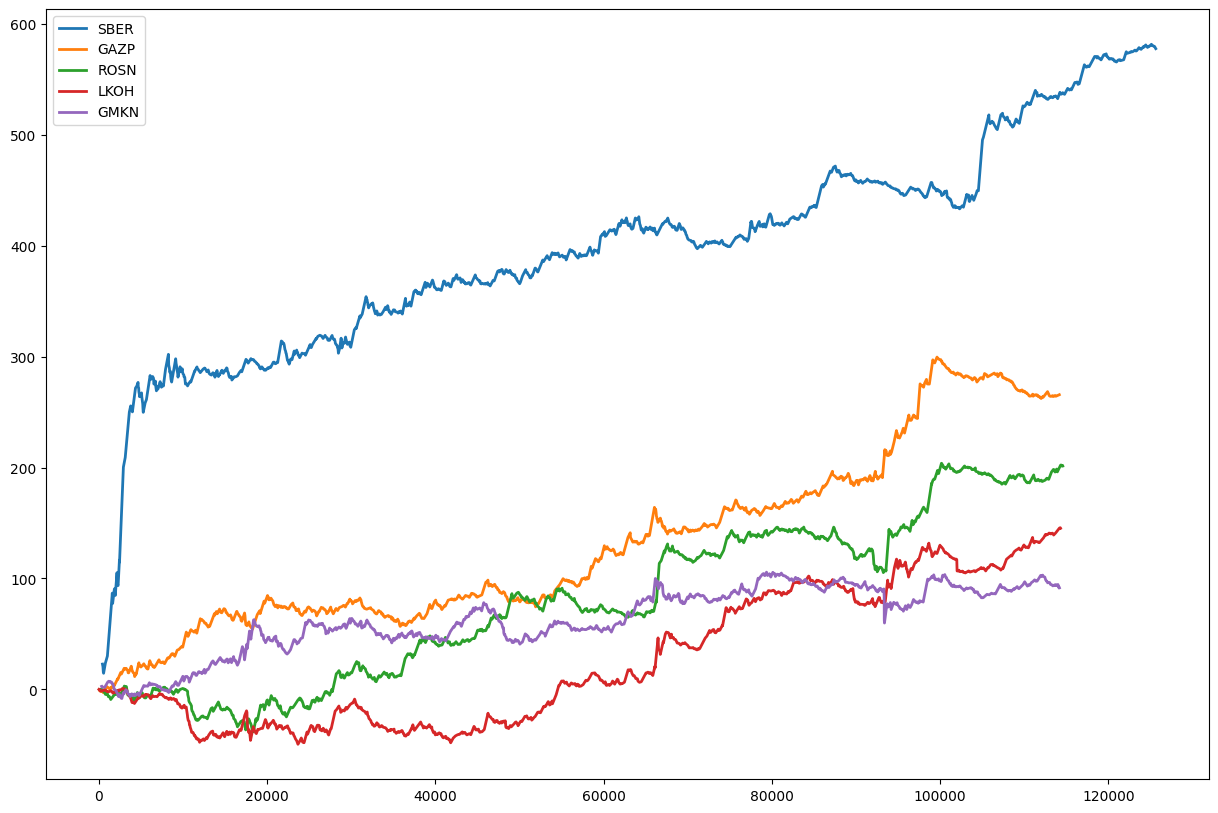

In [98]:
plt.figure(figsize=(15, 10))
opt_res_id = 0
legend = []
for test_id in map(int, opt_res.test_ids.iloc[opt_res_id].split(".")[1:]):
    plt.plot([pos.close_date for pos in btests[test_id].positions], 
             btests[test_id].profits.cumsum(), 
             linewidth=2)
    legend.append(cfgs[test_id].ticker)
plt.legend(legend)

In [18]:
opt_summary_loc = opt_summary[opt_summary.ticker == "ROSN"]
opt_summary_loc.head()

,trailing_stop_rate,trailing_stop_type,body_classifier,stops_processor,wait_entry_point,hist_buffer_size,tstart,tend,period,ticker,data_type,save_plots,btest,ndeals
475,0.04,1,trend:npairs=2,"stops_fix:tp=25,sl=8",9999,30,0,None,M15,ROSN,metatrader,False,352.311404,1094
67,0.01,1,trend:npairs=3,"stops_fix:tp=25,sl=2",9999,30,0,None,M5,ROSN,metatrader,False,318.463341,1410
391,0.02,1,trngl_comp:npairs=3,"stops_fix:tp=25,sl=2",9999,30,0,None,M5,ROSN,metatrader,False,309.361871,2274
283,0.02,1,trend:npairs=3,"stops_fix:tp=25,sl=2",9999,30,0,None,M5,ROSN,metatrader,False,299.720672,1886
457,0.04,1,trend:npairs=2,"stops_fix:tp=25,sl=4",9999,30,0,None,M15,ROSN,metatrader,False,296.919481,1284
